In [28]:
import torch
import  numpy as np
import torchvision as tv
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data  import DataLoader, Dataset, TensorDataset
import matplotlib.pyplot as plt
from PIL import Image
import copy
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import  train_test_split

In [29]:
fdata = datasets.FashionMNIST(root='data',download=True)
test = datasets.FashionMNIST(root='test', train=False, download=True)

In [30]:
fdata.data.shape

torch.Size([60000, 28, 28])

In [31]:
fimages  = fdata.data.view([60000, 1, 28, 28]).float()

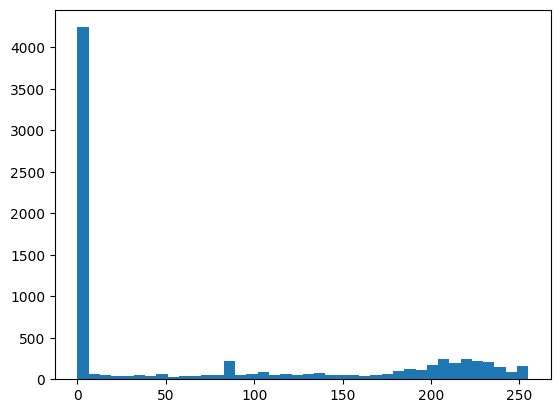

In [32]:
plt.hist(fimages[:10,:,:,:].view(1,-1).detach(),40);
plt.show()

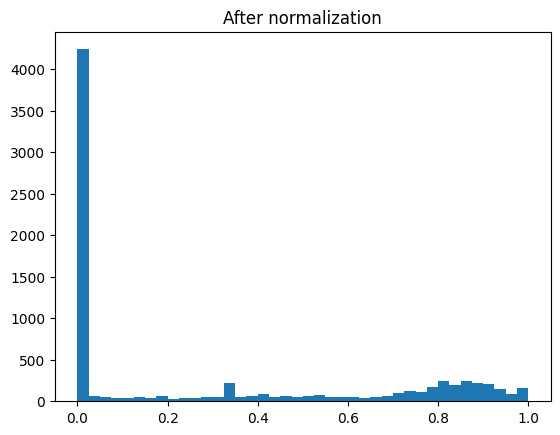

In [33]:
#normalization
fimages /= torch.max(fimages)
plt.hist(fimages[:10,:,:,:].view(1, -1).detach(), 40);
plt.title("After normalization")
plt.show()

In [34]:
fdata.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [35]:
fdata.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [36]:
#indexing labels
fdata.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [37]:
Categories = fdata.classes
labels = copy.deepcopy(fdata.targets)


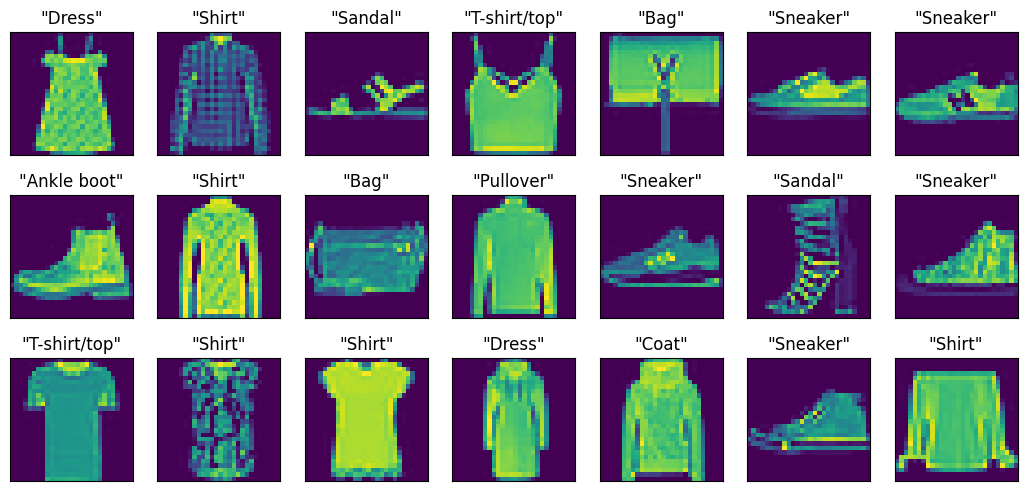

In [38]:
#visualize some images
fig,axs = plt.subplots(3,7, figsize = (13, 6))

for i,ax in enumerate(axs.flatten()):
  #pick a random pic
  whichpic = np.random.randint(fimages.shape[0])

  #extract the image and its target letter
  I = np.squeeze(fimages[whichpic,:,:])
  fclass = Categories[labels[whichpic]]

  #visualize
  ax.imshow(I)
  ax.set_title('"%s"' %fclass)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [39]:
#split the data
train_data, test_data, train_labels, test_labels = train_test_split(fimages, labels, test_size=.1)

#convert into Pytorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

#create DataLoaders for training and testing sets.
#The number of workers is set to 0 so that all processing is done in the main thread.  This is because adding more workers
batch_size=64
num_workers=2

trainloader = DataLoader(dataset=train_data    , batch_size=batch_size, shuffle=True  , num_workers=num_workers)
testloader = DataLoader(dataset=test_data, batch_size=test_data.tensors[0].shape[0])

In [40]:
testloader.dataset.tensors[0].shape

torch.Size([6000, 1, 28, 28])

In [41]:
#DL model
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        #Input shape(batch_size,1,28,28)
        self.conv1 = nn.Conv2d(1,32,3) #Out Shape:(batch_size,32,26,26)
        self.conv2 = nn.Conv2d(32,64,3)

        self.fc1 = nn.Linear(64*5*5,128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        #input: [batch_size,1 ,28,28]
        x = F.relu(self.conv1(x)) #shape: [batch_size, 32,26,26]
        x = F.max_pool2d(x,2) #Out shape: (batch_size, 32, 13, 13)
        x = F.relu(self.conv2(x)) #Out Shape:[batch_size,64,11,11]
        x = F.max_pool2d(x, 2)  #Out  Shape: [batch_size,64,5,5]

        #Flattening
        x = x.view(-1, 64*5*5)
        x = F.relu(self.fc1(x))   #Out Shape :[batch_size,128]
        x = self.fc2(x)           #Out Shape :[batch_size,10]

        return F.log_softmax(x, dim=1)



In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_model().to(device)

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [44]:
#Model Training Function
Epochs = 20

for epochi in range(Epochs):
    model.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images) #forward pass
        loss = criterion(outputs, labels)
        loss.backward()  #backward pass
        optimizer.step()    #optimization step

    print('Epoch: {}/{} - Loss: {:.4f}'.format(epochi+1, Epochs, loss.item()))



Epoch: 1/20 - Loss: 0.2011
Epoch: 2/20 - Loss: 0.5177
Epoch: 3/20 - Loss: 0.4357
Epoch: 4/20 - Loss: 0.0801
Epoch: 5/20 - Loss: 0.2212
Epoch: 6/20 - Loss: 0.2501
Epoch: 7/20 - Loss: 0.2099
Epoch: 8/20 - Loss: 0.3570
Epoch: 9/20 - Loss: 0.1058
Epoch: 10/20 - Loss: 0.2097
Epoch: 11/20 - Loss: 0.2781
Epoch: 12/20 - Loss: 0.0237
Epoch: 13/20 - Loss: 0.2274
Epoch: 14/20 - Loss: 0.1570
Epoch: 15/20 - Loss: 0.0401
Epoch: 16/20 - Loss: 0.0704
Epoch: 17/20 - Loss: 0.0867
Epoch: 18/20 - Loss: 0.0735
Epoch: 19/20 - Loss: 0.1315
Epoch: 20/20 - Loss: 0.0437


In [47]:
#Testing the Model
model.eval()

preds=[]
all_labels=[]
# We don't want to compute gradients during evaluation
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  #get the class with the max probability
        preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, preds, target_names=fdata.classes))
cm = confusion_matrix(all_labels, preds)


              precision    recall  f1-score   support

 T-shirt/top       0.83      0.92      0.87       624
     Trouser       0.98      0.98      0.98       588
    Pullover       0.82      0.88      0.85       583
       Dress       0.92      0.91      0.91       602
        Coat       0.88      0.85      0.86       601
      Sandal       0.99      0.98      0.99       597
       Shirt       0.78      0.71      0.74       623
     Sneaker       0.97      0.96      0.96       610
         Bag       1.00      0.97      0.98       579
  Ankle boot       0.95      0.98      0.96       593

    accuracy                           0.91      6000
   macro avg       0.91      0.91      0.91      6000
weighted avg       0.91      0.91      0.91      6000



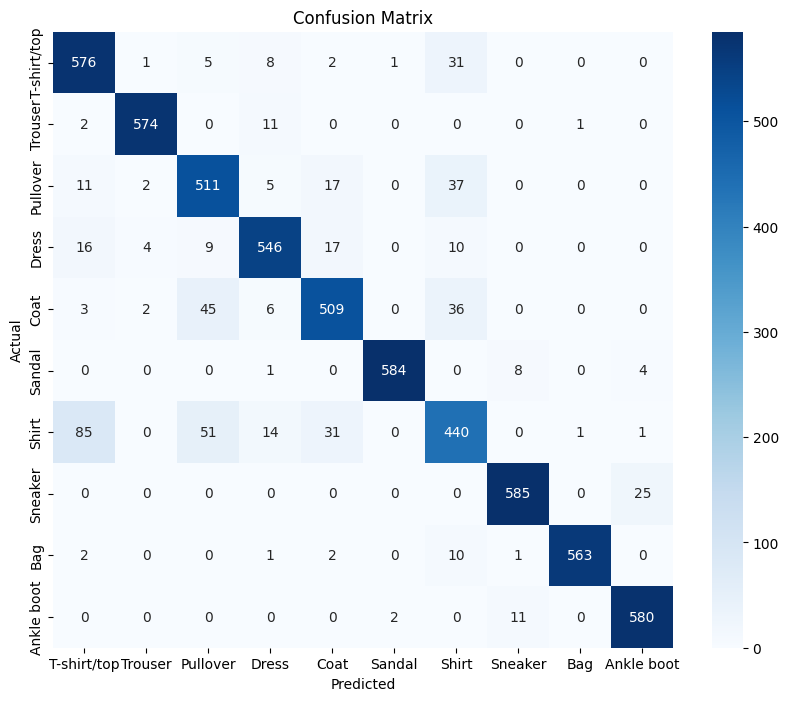

In [46]:
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=fdata.classes, yticklabels=fdata.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()